*LAB-4 17-04-2025 DBN AND DBM*

In [ ]:
#DEEP BOLTZMAN MACHINE
import numpy as np

class DBM:
    def __init__(self, num_visible, num_hidden_layers):
        self.num_visible = num_visible
        self.num_hidden_layers = num_hidden_layers
        self.hidden_sizes = [num_visible // 2] * num_hidden_layers  # Simplified size for hidden layers

        # Initialize weights for each layer
        self.weights = [np.random.normal(0, 0.1, (self.hidden_sizes[i-1] if i > 0 else num_visible, self.hidden_sizes[i]))
                        for i in range(num_hidden_layers)]
        self.visible_bias = np.zeros(num_visible)
        self.hidden_biases = [np.zeros(self.hidden_sizes[i]) for i in range(num_hidden_layers)]

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def sample(self, data, layer_idx, direction):
        if direction == 'hidden':
            activations = np.dot(data, self.weights[layer_idx]) + self.hidden_biases[layer_idx]
        elif direction == 'visible':
            activations = np.dot(data, self.weights[layer_idx].T) + self.visible_bias
        probabilities = self.sigmoid(activations)
        samples = np.random.binomial(1, probabilities)
        return probabilities, samples

    def gibbs_sampling(self, visible_data, steps=10):
        data = visible_data
        for _ in range(steps):
            # Forward pass through hidden layers
            for layer_idx in range(self.num_hidden_layers):
                hidden_prob, hidden_sample = self.sample(data, layer_idx, 'hidden')
                data = hidden_prob

            # Backward pass through visible layer
            visible_prob, visible_sample = self.sample(data, 0, 'visible')
            data = visible_prob

        return visible_prob, data


dbm = DBM(num_visible=4, num_hidden_layers=2)

# Input visible data
visible_data = np.array([[1, 0, 1, 0], [0, 1, 0, 1]])

# Gibbs sampling on the DBM
visible_prob, final_visible_data = dbm.gibbs_sampling(visible_data, steps=10)

print("Visible probabilities after Gibbs sampling:")
print(visible_prob)




Visible probabilities after Gibbs sampling:
[[0.49646967 0.48725011 0.48794753 0.50234454]
 [0.49646967 0.48725011 0.48794753 0.50234454]]


In [ ]:
import numpy as np

class RBM:
    def __init__(self, num_visible, num_hidden):
        self.weights = np.random.normal(0, 0.1, (num_visible, num_hidden))
        self.visible_bias = np.zeros(num_visible)
        self.hidden_bias = np.zeros(num_hidden)

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def train(self, data, num_epochs, learning_rate):
        for epoch in range(num_epochs):
            # Perform Gibbs sampling
            hidden_probs, hidden_samples = self.sample_hidden(data)
            visible_probs, visible_samples = self.sample_visible(hidden_samples)

            # Update weights and biases
            self.update_weights(data, visible_samples, hidden_probs, learning_rate)

            # Output the progress
            if epoch % 10 == 0:
                print(f"Epoch {epoch}/{num_epochs} - Weight update complete")

    def sample_hidden(self, visible_data):
        activations = np.dot(visible_data, self.weights) + self.hidden_bias
        hidden_probs = self.sigmoid(activations)
        return hidden_probs, np.random.binomial(1, hidden_probs)

    def sample_visible(self, hidden_data):
        activations = np.dot(hidden_data, self.weights.T) + self.visible_bias
        visible_probs = self.sigmoid(activations)
        return visible_probs, np.random.binomial(1, visible_probs)

    def update_weights(self, data, visible_samples, hidden_probs, learning_rate):
        positive_grad = np.dot(data.T, hidden_probs)
        negative_grad = np.dot(visible_samples.T, hidden_probs)
        self.weights += learning_rate * (positive_grad - negative_grad) / len(data)
        self.visible_bias += learning_rate * np.mean(data - visible_samples, axis=0)
        self.hidden_bias += learning_rate * np.mean(hidden_probs - hidden_probs, axis=0)


class DBN:
    def __init__(self, layer_sizes):
        self.layer_sizes = layer_sizes
        self.rbms = [RBM(layer_sizes[i], layer_sizes[i + 1]) for i in range(len(layer_sizes) - 1)]

    def pretrain(self, data, num_epochs=10, learning_rate=0.1):
        for i, rbm in enumerate(self.rbms):
            print(f"Pretraining layer {i + 1}...")
            rbm.train(data, num_epochs, learning_rate)

            # Get hidden representations for the next layer
            hidden_probs, _ = rbm.sample_hidden(data)
            data = hidden_probs  # Pass the hidden layer activations to the next layer

    def fine_tune(self, data, labels, learning_rate=0.1, num_epochs=10):
        # Fine-tuning can be done with backpropagation (this part is simplified)
        print("Fine-tuning process (placeholder)")


dbn = DBN([4, 3, 2])  # 4 visible units, 1st hidden layer with 3 units, 2nd hidden layer with 2 units
data = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [1, 1, 0, 0], [0, 0, 1, 1]])  # Dummy data

# Pretrain DBN
print("Starting pretraining...")
dbn.pretrain(data, num_epochs=50)




Starting pretraining...
Pretraining layer 1...
Epoch 0/50 - Weight update complete
Epoch 10/50 - Weight update complete
Epoch 20/50 - Weight update complete
Epoch 30/50 - Weight update complete
Epoch 40/50 - Weight update complete
Pretraining layer 2...
Epoch 0/50 - Weight update complete
Epoch 10/50 - Weight update complete
Epoch 20/50 - Weight update complete
Epoch 30/50 - Weight update complete
Epoch 40/50 - Weight update complete


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import numpy as np


class RBM(nn.Module):
    def __init__(self, visible_units, hidden_units):
        super(RBM, self).__init__()
        self.visible_units = visible_units
        self.hidden_units = hidden_units

        self.W = nn.Parameter(torch.randn(visible_units, hidden_units) * 0.1)
        self.bv = nn.Parameter(torch.zeros(visible_units))
        self.bh = nn.Parameter(torch.zeros(hidden_units))

    def sample_h(self, v):
        h_prob = torch.sigmoid(torch.matmul(v, self.W) + self.bh)
        return h_prob

    def sample_v(self, h):
        v_prob = torch.sigmoid(torch.matmul(h, self.W.t()) + self.bv)
        return v_prob

    def contrastive_divergence(self, v0, k=1):
        v = v0
        for _ in range(k):
            h0 = self.sample_h(v)  # Initial hidden layer activations
            v = self.sample_v(h0)  # Reconstructed visible layer
        h1 = self.sample_h(v)  # Hidden layer after reconstruction


        positive_grad = torch.matmul(v0.t(), h0)
        negative_grad = torch.matmul(v.t(), h1)

        dW = positive_grad - negative_grad
        dbv = torch.sum(v0 - v, 0)
        dbh = torch.sum(h0 - h1, 0)

        return dW, dbv, dbh

    def train_rbm(self, data, learning_rate=0.01, batch_size=10, epochs=10, k=1):
        optimizer = optim.SGD(self.parameters(), lr=learning_rate)

        for epoch in range(epochs):
            for i in range(0, len(data), batch_size):
                batch_data = data[i:i+batch_size]
                v0 = Variable(torch.FloatTensor(batch_data))

                dW, dbv, dbh = self.contrastive_divergence(v0, k)

                optimizer.zero_grad()
                self.W.grad = dW
                self.bv.grad = dbv
                self.bh.grad = dbh
                optimizer.step()
            print(f"Epoch {epoch+1}/{epochs} completed")

    def forward(self, v):
        return self.sample_h(v)


class DBN(nn.Module):
    def __init__(self, layer_sizes, n_classes):
        super(DBN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layer_sizes) - 1):
            self.layers.append(RBM(layer_sizes[i], layer_sizes[i+1]))


        self.fc = nn.Linear(layer_sizes[-1], n_classes)

    def pretrain(self, data, learning_rate=0.01, batch_size=10, epochs=10, k=1):
        for layer in self.layers:
            layer.train_rbm(data, learning_rate, batch_size, epochs, k)

            data = layer.sample_h(torch.FloatTensor(data)).detach().numpy()

    def forward(self, x):

        for layer in self.layers:
            x = layer.sample_h(x)

        return self.fc(x)


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = DataLoader(testset, batch_size=1000, shuffle=False)


def prepare_data(loader):
    data = []
    labels = []
    for images, targets in loader:
        data.append(images.view(images.size(0), -1).numpy())
        labels.append(targets.numpy())
    return np.concatenate(data), np.concatenate(labels)

train_data, train_labels = prepare_data(train_loader)
test_data, test_labels = prepare_data(test_loader)


dbn = DBN([784, 512, 256, 128], 10)  # 784 -> 512 -> 256 -> 128 -> 10 (for MNIST)


dbn.pretrain(train_data, learning_rate=0.01, batch_size=10, epochs=5, k=1)

# Fine-tune the DBN using supervised learning
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(dbn.parameters(), lr=0.1)

num_epochs = 10
for epoch in range(num_epochs):
    dbn.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.view(images.size(0), -1)
        labels = Variable(labels)


        outputs = dbn(images)


        loss = criterion(outputs, labels)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()


        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")


dbn.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(images.size(0), -1)
        labels = Variable(labels)


        outputs = dbn(images)


        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

100%|██████████| 9.91M/9.91M [00:00<00:00, 51.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.70MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.42MB/s]


Epoch 1/5 completed
Epoch 2/5 completed
Epoch 3/5 completed
Epoch 4/5 completed
Epoch 5/5 completed
Epoch 1/5 completed
Epoch 2/5 completed
Epoch 3/5 completed
Epoch 4/5 completed
Epoch 5/5 completed
Epoch 1/5 completed
Epoch 2/5 completed
Epoch 3/5 completed
Epoch 4/5 completed
Epoch 5/5 completed
Epoch [1/10], Loss: 2.3490, Accuracy: 10.27%
Epoch [2/10], Loss: 2.3458, Accuracy: 10.34%
Epoch [3/10], Loss: 2.3463, Accuracy: 10.27%
Epoch [4/10], Loss: 2.3457, Accuracy: 10.17%
Epoch [5/10], Loss: 2.3481, Accuracy: 10.02%
Epoch [6/10], Loss: 2.3469, Accuracy: 10.14%
Epoch [7/10], Loss: 2.3465, Accuracy: 10.20%
Epoch [8/10], Loss: 2.3486, Accuracy: 10.18%
Epoch [9/10], Loss: 2.3305, Accuracy: 10.48%
Epoch [10/10], Loss: 2.3018, Accuracy: 11.22%
Test Accuracy: 11.35%


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7462 - loss: 0.5735
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7597 - loss: 0.4954
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7541 - loss: 0.5024
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7553 - loss: 0.4968
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7549 - loss: 0.4957
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7563 - loss: 0.4943
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7559 - loss: 0.4977
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7588 - loss: 0.4935
Epoch 9/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7611 - loss: 0.4905
Epoch 10/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7559 - loss: 0.4940
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7560 - loss: 0.4923
Test accuracy for DBN: 76.31%


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Test accuracy for traditional DNN: 84.97%


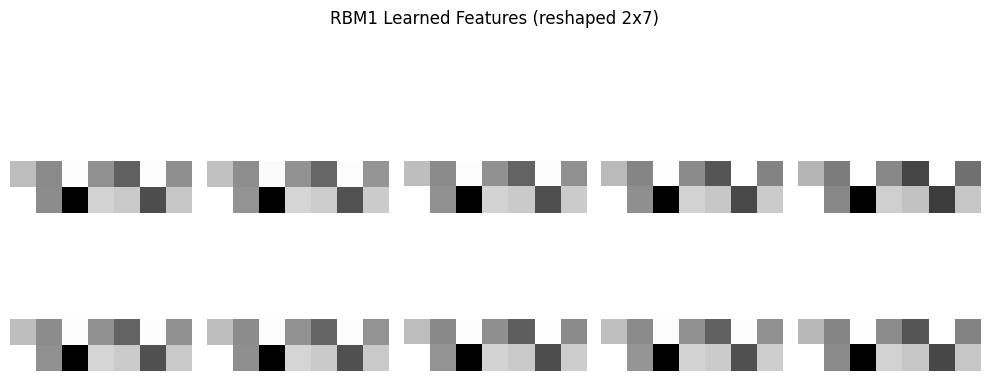

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import BernoulliRBM
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
                'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
                'hours_per_week', 'native_country', 'income']


data = pd.read_csv(url, names=column_names, na_values=" ?", sep=',\s+', engine='python')


data.dropna(inplace=True)


categorical_columns = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country', 'income']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

X = data.drop('income', axis=1).values
y = data['income'].values


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


n_hidden_1 = 128
n_hidden_2 = 64


rbm1 = BernoulliRBM(n_components=n_hidden_1, learning_rate=0.1, n_iter=10, random_state=42)
X_train_rbm1 = rbm1.fit_transform(X_train)

rbm2 = BernoulliRBM(n_components=n_hidden_2, learning_rate=0.1, n_iter=10, random_state=42)
X_train_rbm2 = rbm2.fit_transform(X_train_rbm1)


model_dbn = Sequential()
model_dbn.add(Dense(64, input_dim=n_hidden_2, activation='relu'))
model_dbn.add(Dense(32, activation='relu'))
model_dbn.add(Dense(1, activation='sigmoid'))

model_dbn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_dbn.fit(X_train_rbm2, y_train, epochs=10, batch_size=128)

X_test_rbm1 = rbm1.transform(X_test)
X_test_rbm2 = rbm2.transform(X_test_rbm1)

test_loss, test_acc = model_dbn.evaluate(X_test_rbm2, y_test)
print(f"Test accuracy for DBN: {test_acc * 100:.2f}%")

mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=10, solver='adam', random_state=42)
mlp.fit(X_train, y_train)


y_pred = mlp.predict(X_test)
traditional_acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy for traditional DNN: {traditional_acc * 100:.2f}%")


plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(rbm1.components_[i].reshape(2, 7), cmap='gray')
    plt.axis('off')
plt.suptitle("RBM1 Learned Features (reshaped 2x7)")
plt.tight_layout()
plt.show()

